In [11]:
import sys
sys.executable

'C:\\Users\\Nicol\\AppData\\Local\\Microsoft\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\python.exe'

In [12]:
import numpy as np
import sklearn
from sklearn import model_selection
import matplotlib as mpl
import scipy as sp
import pandas as pd
import os

In [13]:
# Function that we use to plot surfaces for visualization of parameters or features
def surf(Z, colormap, X=None, Y=None):
    import numpy as np
    import matplotlib.pyplot as pplot
    
    # We adjust the size of X and Y so that we show the ENTIRE grid Z
    if X is None:
        X = np.arange(Z.shape[1] + 1)
    if Y is None:
        Y = np.arange(Z.shape[0] + 1)

    # Set the figure and axis variables
    fig = pplot.figure()
    ax = fig.gca()
    
    # Display the mesh
    mysurf = ax.pcolormesh(X, Y, Z, shading = 'flat', vmin=Z.min(),
                                 vmax = Z.max(),cmap = colormap)
    
    # Display the colorbar for the mesh axis
    fig.colorbar(mysurf, ax=ax)
    
    return surf

# Function that we use to tune our REGRESSION models using a specified Validation proportion of our Training Set
def TuningModels(models, X, Y, val_size, iterations = 100):
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn import metrics
    results = {}
    for i in models:
        metric_train = []
        metric_val = []
        for j in range(iterations):
            X_train, X_val, y_train, y_val = train_test_split(X,Y,test_size = val_size)
            metric_val.append(metrics.mean_squared_error(y_val,
                                                     models[i].fit(X_train,
                                                                   y_train).predict(X_val)))
            metric_train.append(metrics.mean_squared_error(y_train,
                                                       models[i].fit(X_train, 
                                                                     y_train).predict(X_train)))
        results[i] = [np.mean(metric_train), np.mean(metric_val)]
    return results

# Function that we use to tune our CLASSIFICATION models using a specified Validation proportion of our Training Set
def TuningModelsClassif(models,X,Y,val_size,iterations=100):
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn import metrics
    results = {}
    for i in models:
        metric_train = []
        metric_val = []
        for j in range(iterations):
            X_train, X_val, y_train, y_val = train_test_split(X,Y,test_size = val_size)
            metric_val.append(metrics.f1_score(y_val,
                                               models[i].fit(X_train,
                                                             y_train).predict(X_val)))
            metric_train.append(metrics.f1_score(y_train,
                                                 models[i].fit(X_train, 
                                                                     y_train).predict(X_train)))
        results[i] = [np.mean(metric_train), np.mean(metric_val)]
    return results

In [36]:
# Function to calculate the SFScore using kmeans
def SFScore_kmeans(InData,kval):
    # Will return WCD, BCD, SF, and SI
    # Saitta et al. (2008): Intelligent Data Analysis 12 (2008) 529–548 529
    # "A comprehensive validity index for clustering"
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import scale
    from sklearn.metrics import silhouette_score as SI
    from numpy.matlib import repmat
    import numpy as np
    
    NValues = InData.shape[0]
    scaleData = scale(InData,axis=0)
    
    sk_KMeans = KMeans(n_clusters = kval,
                       init = 'k-means++',
                       n_init = 1,
                       max_iter = 1000,
                       tol = 1e-10,
                       verbose = 0,
                       algorithm = "auto")
    sk_KMeans.fit(scaleData)
    pred_classes_sk = sk_KMeans.labels_
    sk_centroids = sk_KMeans.cluster_centers_
    
    # The code below is not efficient. However, it breaks down the steps so that they should be comprehensible.
    # If you found that your own code repeatedly gave you values of Infinity, then
    # you did not fully comprehend the paper's equations and you were not able to
    # successfully translate the equations into ML code
    # Please go through this code and see where you were making mistakes.
    
    # Calculate within cluster distance (WCD)
    # Saitta et al. (2008): Intelligent Data Analysis 12 (2008) 529–548 529
    # "A comprehensive validity index for clustering"
    # Equation 11
    InClust_WCD = np.empty(shape=(kval,1))
    AllNValuesInCluster = np.empty(shape=(kval,1),dtype=int)
    for clust_num in range(0,kval):
        clust_indices = np.where(pred_classes_sk == clust_num)
        clust_data = np.squeeze(scaleData[clust_indices,:])
        # Keep in mind Features go across columns, cases down rows
        NValuesInCluster = np.size(clust_indices)
        RepMat = repmat(sk_centroids[clust_num,:],NValuesInCluster,1)
        InClust_WCD[clust_num] = np.sqrt((1/NValuesInCluster) * np.sum(np.sum(np.square(clust_data - RepMat),1))) # In Square Root in Equation 11
        AllNValuesInCluster[clust_num] = NValuesInCluster
    WCD = (1/kval) * np.sum(InClust_WCD) # From Equation 11
    
    # Calculate between cluster distance (BCD)
    # Saitta et al. (2008): Intelligent Data Analysis 12 (2008) 529–548 529
    # "A comprehensive validity index for clustering"
    # Equation 10
    AllCentroid = np.mean(scaleData,axis=0) # Should be near 0 for each feature due to centering & scaling
    RepMat2 = repmat(AllCentroid,kval,1)
    BCD1 = np.sum(np.square(sk_centroids - RepMat2),axis=1)
    BCD2 = np.multiply(AllNValuesInCluster.transpose(),BCD1) # Element-by-Element Multiplication
    BCD3 = np.sum(BCD2)
    BCD = (1/(NValues*kval)) * BCD3
    
    SFScore = 1 - (1/(np.exp(np.exp(BCD - WCD))))
    
    SIScore = SI(scaleData,pred_classes_sk)
    
    # Return the important values
    return WCD, BCD, SFScore, SIScore

In [15]:
# Get ready to import the .mat file with the EEG data features
# DataDir = '/Users/Nicol/OneDrive - g.hmc.edu/FA2022/NEUR182/'
DataDir = '/Users/Nicol/OneDrive - g.hmc.edu/FA2022/NEUR182/'
DataFileName = 'C1_EncMain_FeatureData.mat'
FullDataFileName = os.path.join(DataDir,DataFileName)
import scipy.io
# Import the data
FeatDataDict = scipy.io.loadmat(FullDataFileName)
# Convert to numpy array
temp1 = FeatDataDict.items()
temp2 = list(temp1)
temp3 = np.array(temp2)
temp4 = temp3[3]
FeatData = temp4[1]




C:\Users\Nicol\AppData\Local\Temp\ipykernel_8600\2910561263.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp3 = np.array(temp2)


In [17]:
DataDir = '/Users/Nicol/OneDrive - g.hmc.edu/FA2022/NEUR182/'
DataFileNameFeat = 'MDDXFeatures.csv'
FullDataFileName = os.path.join(DataDir,DataFileNameFeat)

PVs = np.genfromtxt(FullDataFileName, dtype=float, delimiter=',')

DataFileName_HvMDD = 'MDDY_HvMDD.csv'
FullDataFileName = os.path.join(DataDir,DataFileName_HvMDD)

OV_HvMDD = np.genfromtxt(FullDataFileName, dtype=float, delimiter=',')
OV_HvMDD = [0 if x == 1 else 1 for x in OV_HvMDD]

DataFileName_RvNR = 'MDDY_RvNR.csv'
FullDataFileName = os.path.join(DataDir,DataFileName_RvNR)

OV_RvNR = np.genfromtxt(FullDataFileName, dtype=float, delimiter=',')

In [129]:
OV_HvMDD

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [18]:
#pipeline for scaling and centering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

scaling_pipeline = Pipeline([
    ('std_scaler', MinMaxScaler())
])

In [19]:
PVs_scaled = scaling_pipeline.fit_transform(PVs)

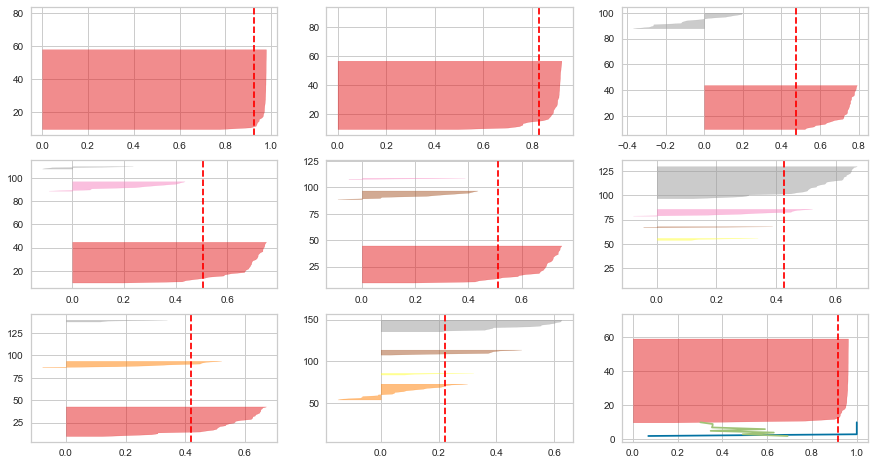

In [82]:
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

init_method = 'k-means++'
n_init = 100
max_iter = 1000
usetol = 1e-10
verbose = 0
random_state = 100
algorithm = "auto"

fig1, ax1 = plt.subplots(3, 3, figsize=(15,8))

sf_scores = [0]*9
si_scores = [0]*9
for i in range(2,11):
    km = KMeans(n_clusters = i,
                   init = init_method,
                   n_init = n_init,
                   max_iter = max_iter,
                   tol = usetol,
                   verbose = verbose,
                   random_state = random_state,
                   algorithm = algorithm)

    q, mod = divmod(i, 3)

    visualizer = SilhouetteVisualizer(km, ax=ax1[q-1][mod])
    visualizer.fit(PVs)

    _, _, sf_scores[i-2], si_scores[i-2] = SFScore_kmeans(PVs, i)



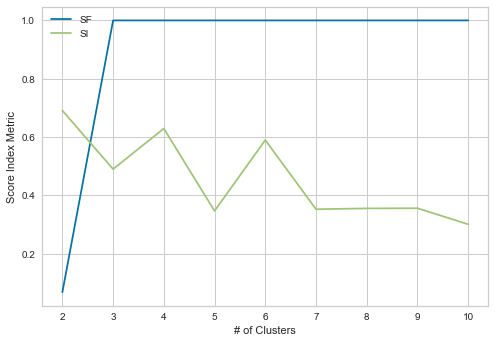

In [85]:
plt.plot(range(2,11), sf_scores, label='SF')
plt.plot(range(2,11), si_scores, label='SI')
plt.xlabel('# of Clusters')
plt.ylabel('Score Index Metric')
plt.legend()
plt.show()

In [24]:
PV_train, PV_test = model_selection.train_test_split(PVs_scaled, test_size=0.2, random_state=42)
OV_HvMDD_train, OV_HvMDD_test = model_selection.train_test_split(OV_HvMDD, test_size=0.2, random_state=42)
OV_RvNR_train, OV_RvNR_test = model_selection.train_test_split(OV_RvNR, test_size=0.2, random_state=42)

#  OLS Logistic and Multinomial Logistic Regression

OLS LogReg AUC = 0.45000000000000007
OLS LogReg BalAcc = 0.45
OLS LogReg F1 = 0.5


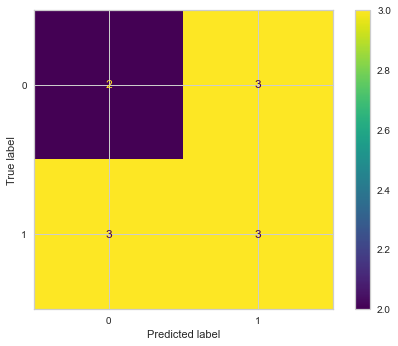

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
OLSLogReg = LogisticRegression(penalty = 'none', tol = 1e-3, random_state = 100, solver = 'lbfgs')
OLSLogReg.fit(PV_train, OV_HvMDD_train)
OLSLogRegPredictTest = OLSLogReg.predict(PV_test)
OLSLogRegAUC = metrics.roc_auc_score(OV_HvMDD_test, OLSLogRegPredictTest)
print('OLS LogReg AUC = ' + str(OLSLogRegAUC))
OLSLogRegBalAcc = metrics.balanced_accuracy_score(OV_HvMDD_test,OLSLogRegPredictTest)
print('OLS LogReg BalAcc = ' + str(OLSLogRegBalAcc))
OLSLogRegF1 = metrics.f1_score(OV_HvMDD_test,OLSLogRegPredictTest)
print('OLS LogReg F1 = ' + str(OLSLogRegF1))

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(OV_HvMDD_test, OLSLogRegPredictTest)).plot()

In [ ]:
print('F1 score:', metrics.f1_score(y_true, y_pred))
print('Balanced Accuracy:', metrics.balanced_accuracy_score(y_true, y_pred))
print('Matthews Correlation Coefficient:', metrics.matthews_corrcoef(y_true, y_pred))
print('Log Loss:', metrics.log_loss(y_true, y_pred))

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_true, y_pred)).plot()

In [130]:
# Set up our models
from sklearn.model_selection import GridSearchCV
lasso_params = {'C':np.linspace(1e-10,100,100)}
ridge_params = {'C':np.linspace(1e-10,100,100)}
elastic_params = {'C':np.linspace(1e-10,100,100), 'l1_ratio':np.linspace(0,1,20)}

# Solvers: lbfgs for all but L1 regularization; saga for L1 regularization
# See: https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451

models = {'OLS': LogisticRegression(penalty = 'none',tol = 1e-3, random_state=100,
                                                solver = 'lbfgs', n_jobs=-1),
          'Lasso': GridSearchCV(LogisticRegression(penalty = 'l1',tol = 1e-3, random_state=100,
                                                  solver = 'saga', n_jobs=-1), 
                                param_grid=lasso_params).fit(PV_train, OV_HvMDD_train).best_estimator_,
          'Ridge': GridSearchCV(LogisticRegression(penalty = 'l2', tol = 1e-3, random_state = 100,
                                                               solver = 'lbfgs', n_jobs=-1),
                                 param_grid=ridge_params).fit(PV_train, OV_HvMDD_train).best_estimator_,
          'Elastic': GridSearchCV(LogisticRegression(penalty = 'elasticnet', tol = 1e-3, random_state = 100,
                                                     solver = 'saga', n_jobs=-1),
                                  param_grid=elastic_params).fit(PV_train, OV_HvMDD_train).best_estimator_}
 
MyRes = TuningModelsClassif(models, PV_train, OV_HvMDD_train, val_size = 0.2, iterations = 100)

C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:352: Conve

In [16]:
models['Elastic'].l1_ratio

0.0

In [17]:
# Examine the best lambda (alpha) values
print('Optimal Lambda for LASSO = ' + str(1/models['Lasso'].C))
print('Optimal Lambda for Ridge = ' + str(1/models['Ridge'].C))
print('Optimal Lambda for Elastic = ' + str(1/models['Elastic'].C))
print('Optimal L1 Ratio for Elastic = ' + str(1/models['Elastic'].l1_ratio))

Optimal Lambda for LASSO = 0.9899999999029799
Optimal Lambda for Ridge = 0.32999999998943996
Optimal Lambda for Elastic = 0.9899999999029799
Optimal L1 Ratio for Elastic = inf


C:\Users\Nick Tekieli\AppData\Local\Temp\ipykernel_5632\3676783522.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  print('Optimal L1 Ratio for Elastic = ' + str(1/models['Elastic'].l1_ratio))


OLS LogReg AUC = 0.45000000000000007
OLS LogReg BalAcc = 0.45
OLS LogReg F1 = 0.5
Matthews Correlation Coefficient: -0.1
Log Loss: 18.839550651068606
Lasso LogReg AUC = 0.5333333333333333
Lasso LogReg BalAcc = 0.5333333333333333
Lasso LogReg F1 = 0.6153846153846153
Matthews Correlation Coefficient: 0.06900655593423542
Log Loss: 15.699661887894907
Ridge LogReg AUC = 0.5333333333333333
Ridge LogReg BalAcc = 0.5333333333333333
Ridge LogReg F1 = 0.6153846153846153
Matthews Correlation Coefficient: 0.06900655593423542
Log Loss: 15.699661887894907
Elastic LogReg AUC = 0.5333333333333333
Elastic LogReg BalAcc = 0.5333333333333333
Elastic LogReg F1 = 0.6153846153846153
Matthews Correlation Coefficient: 0.06900655593423542
Log Loss: 15.699661887894907


C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


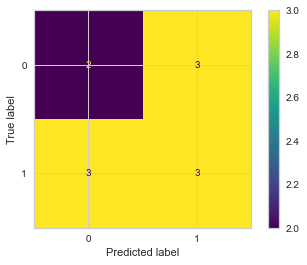

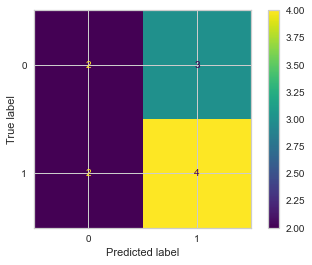

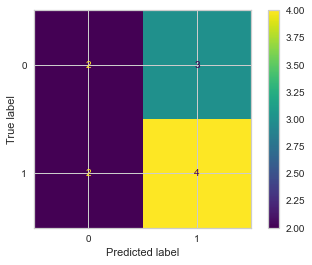

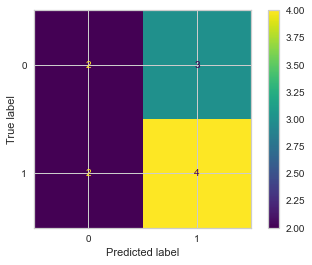

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
OLSLogReg = LogisticRegression(penalty = 'none', tol = 1e-3, random_state = 100, solver = 'lbfgs')
OLSLogReg.fit(PV_train, OV_HvMDD_train)
OLSLogRegPredictTest = OLSLogReg.predict(PV_test)
OLSLogRegAUC = metrics.roc_auc_score(OV_HvMDD_test, OLSLogRegPredictTest)
print('OLS LogReg AUC = ' + str(OLSLogRegAUC))
OLSLogRegBalAcc = metrics.balanced_accuracy_score(OV_HvMDD_test, OLSLogRegPredictTest)
print('OLS LogReg BalAcc = ' + str(OLSLogRegBalAcc))
OLSLogRegF1 = metrics.f1_score(OV_HvMDD_test, OLSLogRegPredictTest)
print('OLS LogReg F1 = ' + str(OLSLogRegF1))

print('Matthews Correlation Coefficient:', metrics.matthews_corrcoef(OV_HvMDD_test, OLSLogRegPredictTest))
print('Log Loss:', metrics.log_loss(OV_HvMDD_test, OLSLogRegPredictTest))

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(OV_HvMDD_test, OLSLogRegPredictTest)).plot()

LassoLogReg = LogisticRegression(penalty = 'l1', tol = 1e-3, random_state = 100, solver = 'saga',
                                C = models['Lasso'].C)
LassoLogReg.fit(PV_train, OV_HvMDD_train)
LassoLogRegPredictTest = LassoLogReg.predict(PV_test)
LassoLogRegAUC = metrics.roc_auc_score(OV_HvMDD_test, LassoLogRegPredictTest)
print('Lasso LogReg AUC = ' + str(LassoLogRegAUC))
LassoLogRegBalAcc = metrics.balanced_accuracy_score(OV_HvMDD_test, LassoLogRegPredictTest)
print('Lasso LogReg BalAcc = ' + str(LassoLogRegBalAcc))
LassoLogRegF1 = metrics.f1_score(OV_HvMDD_test, LassoLogRegPredictTest)
print('Lasso LogReg F1 = ' + str(LassoLogRegF1))

print('Matthews Correlation Coefficient:', metrics.matthews_corrcoef(OV_HvMDD_test, LassoLogRegPredictTest))
print('Log Loss:', metrics.log_loss(OV_HvMDD_test, LassoLogRegPredictTest))

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(OV_HvMDD_test, LassoLogRegPredictTest)).plot()

RidgeLogReg = LogisticRegression(penalty = 'l2', tol = 1e-3, random_state = 100, solver = 'lbfgs',
                                C = models['Ridge'].C)
RidgeLogReg.fit(PV_train, OV_HvMDD_train)
RidgeLogRegPredictTest = RidgeLogReg.predict(PV_test)
RidgeLogRegAUC = metrics.roc_auc_score(OV_HvMDD_test, RidgeLogRegPredictTest)
print('Ridge LogReg AUC = ' + str(RidgeLogRegAUC))
RidgeLogRegBalAcc = metrics.balanced_accuracy_score(OV_HvMDD_test, RidgeLogRegPredictTest)
print('Ridge LogReg BalAcc = ' + str(RidgeLogRegBalAcc))
RidgeLogRegF1 = metrics.f1_score(OV_HvMDD_test, RidgeLogRegPredictTest)
print('Ridge LogReg F1 = ' + str(RidgeLogRegF1))

print('Matthews Correlation Coefficient:', metrics.matthews_corrcoef(OV_HvMDD_test, RidgeLogRegPredictTest))
print('Log Loss:', metrics.log_loss(OV_HvMDD_test, RidgeLogRegPredictTest))

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(OV_HvMDD_test, RidgeLogRegPredictTest)).plot()

ElasticLogReg = LogisticRegression(penalty = 'elasticnet', tol = 1e-3, random_state = 100, solver = 'saga',
                                C = models['Elastic'].C, l1_ratio = 1)
ElasticLogReg.fit(PV_train, OV_HvMDD_train)
ElasticLogRegPredictTest = RidgeLogReg.predict(PV_test)
ElasticLogRegAUC = metrics.roc_auc_score(OV_HvMDD_test, ElasticLogRegPredictTest)
print('Elastic LogReg AUC = ' + str(ElasticLogRegAUC))
ElasticLogRegBalAcc = metrics.balanced_accuracy_score(OV_HvMDD_test, ElasticLogRegPredictTest)
print('Elastic LogReg BalAcc = ' + str(ElasticLogRegBalAcc))
ElasticLogRegF1 = metrics.f1_score(OV_HvMDD_test, ElasticLogRegPredictTest)
print('Elastic LogReg F1 = ' + str(ElasticLogRegF1))

print('Matthews Correlation Coefficient:', metrics.matthews_corrcoef(OV_HvMDD_test, ElasticLogRegPredictTest))
print('Log Loss:', metrics.log_loss(OV_HvMDD_test, ElasticLogRegPredictTest))

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(OV_HvMDD_test, ElasticLogRegPredictTest)).plot()

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(OV_RvNR_train)
y_onehot_test = label_binarizer.transform(OV_RvNR_test)
y_onehot_test.shape  # (n_samples, n_classes)

(11, 3)

In [98]:
OLSLogReg = LogisticRegression(multi_class='multinomial', penalty = 'none', tol = 1e-3, random_state = 100, solver = 'lbfgs')
OLSLogReg.fit(PV_train, OV_HvMDD_train)
OLSLogRegPredictProbaTest = OLSLogReg.predict_proba(PV_test)
OLSLogRegPredictTest = OLSLogReg.predict(PV_test)
OLSLogRegAUC = metrics.roc_auc_score(y_onehot_test, OLSLogRegPredictProbaTest, multi_class='ovr')
print('OLS LogReg AUC = ' + str(OLSLogRegAUC))
OLSLogRegBalAcc = metrics.balanced_accuracy_score(OV_RvNR_test, OLSLogRegPredictTest)
print('OLS LogReg BalAcc = ' + str(OLSLogRegBalAcc))
OLSLogRegF1 = metrics.f1_score(OV_RvNR_test, OLSLogRegPredictTest, average='micro')
print('OLS LogReg F1 = ' + str(OLSLogRegF1))

OLS LogReg AUC = 0.46458333333333335
OLS LogReg BalAcc = 0.24444444444444446
OLS LogReg F1 = 0.2727272727272727


#  Linear and RBF Support Vector Machines

In [133]:
import sklearn.metrics as metrics
# Train the classifier
# Specify parameters
kernel_choice = 'linear'
# C is the Regularizaton Parameter
# C Multiplies the Loss Function
# So the lower C is, the Softer the penalty for violating the boundaries
# So the higher C is, the Harder the penalty for violating the boundaries
# C is related to the "slack variable", which determines how fuzzy the classificaton
# boundaries are
C = 10000
gamma_choice = 'auto' # irrelevant for linear kernels
degree_choice = 10 #irrelevant unless there is a polynomial kernel

# Specify our object
from sklearn.svm import SVC
MySVC = SVC(C = C, kernel = kernel_choice, gamma = gamma_choice, degree = degree_choice, random_state=100)

# Train our SVC
from sklearn.preprocessing import scale as CenterScale
MySVC.fit(CenterScale(PV_train), OV_HvMDD_train)

SVC(C=10000, degree=10, gamma='auto', kernel='linear', random_state=100)

In [134]:
# Explore our classifier
print('Number of Support Vectors for each Class = ' + str(MySVC.n_support_))
#print('Median of Feature Weights (only available for Linear Kernel) = ' + str(np.median(MySVC.coef_)))
#print('Maximum of Feature Weights (only available for Linear Kernel) = ' + str(np.max(MySVC.coef_)))

Number of Support Vectors for each Class = [9 8]


AUC = 0.7333333333333333
Balanced Accuracy = 0.7333333333333334
F1 = 0.7272727272727272
Matthews Correlation Coefficient: 0.4666666666666667
Log Loss: 9.419738980196568


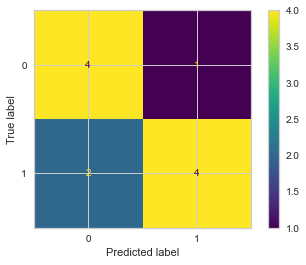

In [135]:
# Test the classifier
TestPred = MySVC.predict(CenterScale(PV_test))
AUCResult = metrics.roc_auc_score(OV_HvMDD_test, TestPred)
print('AUC = ' + str(AUCResult))
BalAccResult = metrics.balanced_accuracy_score(OV_HvMDD_test, TestPred)
print('Balanced Accuracy = ' + str(BalAccResult))
F1Result = metrics.f1_score(OV_HvMDD_test, TestPred)
print('F1 = ' + str(F1Result))

print('Matthews Correlation Coefficient:', metrics.matthews_corrcoef(OV_HvMDD_test, TestPred))
print('Log Loss:', metrics.log_loss(OV_HvMDD_test, TestPred))

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(OV_HvMDD_test, TestPred)).plot()

In [102]:
# Train the classifier
# Specify parameters
kernel_choice = 'rbf'
# C is the Regularizaton Parameter
# C Multiplies the Loss Function
# So the lower C is, the Softer the penalty for violating the boundaries
# So the higher C is, the Harder the penalty for violating the boundaries
# C is related to the "slack variable", which determines how fuzzy the classificaton
# boundaries are
C = 10000
gamma_choice = 'auto' # irrelevant for linear kernels
degree_choice = 10 #irrelevant unless there is a polynomial kernel

# Specify our object
from sklearn.svm import SVC
MySVC = SVC(C = C, kernel = kernel_choice, gamma = gamma_choice, degree = degree_choice, random_state=100, probability=True)

# Train our SVC
from sklearn.preprocessing import scale as CenterScale
MySVC.fit(CenterScale(PV_train), OV_RvNR_train)

SVC(C=10000, degree=10, gamma='auto', probability=True, random_state=100)

In [103]:
# Explore our classifier
print('Number of Support Vectors for each Class = ' + str(MySVC.n_support_))
#print('Median of Feature Weights (only available for Linear Kernel) = ' + str(np.median(MySVC.coef_)))
#print('Maximum of Feature Weights (only available for Linear Kernel) = ' + str(np.max(MySVC.coef_)))

Number of Support Vectors for each Class = [11  7 13]


In [105]:
# Test the classifier
TestPred = MySVC.predict(CenterScale(PV_test))
TestPredProba = MySVC.predict_proba(CenterScale(PV_test))
AUCResult = metrics.roc_auc_score(y_onehot_test, TestPredProba, multi_class='ovr')
print('AUC = ' + str(AUCResult))
BalAccResult = metrics.balanced_accuracy_score(OV_RvNR_test, TestPred)
print('Balanced Accuracy = ' + str(BalAccResult))
F1Result = metrics.f1_score(OV_RvNR_test, TestPred, average='micro')
print('F1 = ' + str(F1Result))

AUC = 0.4305555555555556
Balanced Accuracy = 0.35555555555555557
F1 = 0.36363636363636365


# XGBoost

AUC = 0.6166666666666667
Balanced Accuracy = 0.6166666666666667
F1 = 0.7142857142857143
Matthews Correlation Coefficient: 0.2608745973749754
Log Loss: 12.55977312472121


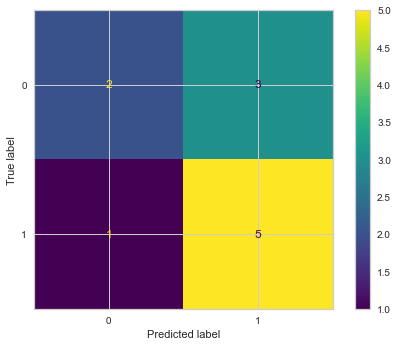

In [109]:
from xgboost import XGBClassifier
XGBReg = XGBClassifier()
XGBReg.fit(PV_train, OV_HvMDD_train)

# Test the classifier
TestPred = XGBReg.predict(PV_test)
AUCResult = metrics.roc_auc_score(OV_HvMDD_test, TestPred)
print('AUC = ' + str(AUCResult))
BalAccResult = metrics.balanced_accuracy_score(OV_HvMDD_test, TestPred)
print('Balanced Accuracy = ' + str(BalAccResult))
F1Result = metrics.f1_score(OV_HvMDD_test, TestPred)
print('F1 = ' + str(F1Result))

print('Matthews Correlation Coefficient:', metrics.matthews_corrcoef(OV_HvMDD_test, TestPred))
print('Log Loss:', metrics.log_loss(OV_HvMDD_test, TestPred))

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(OV_HvMDD_test, TestPred)).plot()

In [110]:
# Use XGBoost algorithm
import xgboost as xgb
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve
from copy import deepcopy
import time
import warnings




xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
xgbc0.fit(PV_train, OV_HvMDD_train)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgbc0, scoring='accuracy', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(PV_train, OV_HvMDD_train)

#results dataframe
df = pd.DataFrame(clf0.cv_results_)

#predictions - inputs to confusion matrix
train_predictions = clf0.predict(PV_train)
test_predictions = clf0.predict(PV_test)

#confusion matrices
cfm_train = confusion_matrix(OV_HvMDD_train, train_predictions)
cfm_test = confusion_matrix(OV_HvMDD_test, test_predictions)

#accuracy scores
accs_train = roc_auc_score(OV_HvMDD_train, train_predictions)
accs_test = roc_auc_score(OV_HvMDD_test, test_predictions)

#F1 scores for each train/test label
f1s_train_p1 = f1_score(OV_HvMDD_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(OV_HvMDD_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(OV_HvMDD_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(OV_HvMDD_test, test_predictions, pos_label=0)

#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(OV_HvMDD_test, clf0.predict_proba(PV_test)[:,1])

#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
#dictionary for collecting results
results_dict = {}
results_dict['xgbc0'] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'cfm_train': cfm_train,
                         'cfm_test': cfm_test,
                         'train_accuracy': accs_train,
                         'test_accuracy': accs_test,
                         'train F1-score label 1': f1s_train_p1,
                         'train F1-score label 0': f1s_train_p0,
                         'test F1-score label 1': f1s_test_p1,
                         'test F1-score label 0': f1s_test_p0,
                         'test roc auc score': test_ras,
                         'best_params': bp}
print(bp)
print(accs_test)

C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\s

Fitting 3 folds for each of 1 candidates, totalling 3 fits
{'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'auc', 'feature_types': None, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'lossguide', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_bin': 256, 'max_cat_threshold': 64, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 6, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'objective': 'binary:logistic', 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'hist', 'use_label_encoder': False, 'validate_parameters': 1, 'verbosity': None}
0.7


C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [111]:
# Now tune using GridSearchCV
# See: https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d

#creating deepcopy of default parameters before manipulations
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

#start time
t0 = time.time()
#No. of jobs
gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

#iteration loop. Each selected parameter iterated separately
for i,grid_key in enumerate(param_grid.keys()):
    
    #variable for measuring iteration time
    loop_start = time.time()
       
    #creating param_grid argument for GridSearchCV:
    #listing grid values of current iterable parameter and wrapping non-iterable parameter single values in list
    for param_key in params.keys():
        if param_key == grid_key:
            params[param_key] = param_grid[grid_key]
        else:
            #use best parameters of last iteration
            try:
                param_value = [clf.best_params_[param_key]]
                params[param_key] = param_value
            #use benchmark model parameters for first iteration
            except:
                param_value = [clf0.best_params_[param_key]]
                params[param_key] = param_value
    
    #classifier instance of current iteration
    xgbc = xgb.XGBClassifier(**default_params)
    
    #GridSearch instance of current iteration
    clf = GridSearchCV(estimator=xgbc, param_grid=params,
                       scoring='roc_auc',
                       return_train_score=True,
                       verbose=1, cv=3, n_jobs = 3)
    clf.fit(PV_train, OV_HvMDD_train)
    
    #results dataframe
    df = pd.DataFrame(clf.cv_results_)
    
    #predictions - inputs to confusion matrix
    train_predictions = clf.predict(PV_train)
    test_predictions = clf.predict(PV_test)
    
    #confusion matrices
    cfm_train = confusion_matrix(OV_HvMDD_train, train_predictions)
    cfm_test = confusion_matrix(OV_HvMDD_test, test_predictions)
    
    #accuracy scores
    accs_train = roc_auc_score(OV_HvMDD_train, train_predictions)
    accs_test = roc_auc_score(OV_HvMDD_test, test_predictions)
    
    #F1 scores for each train/test label
    f1s_train_p1 = f1_score(OV_HvMDD_train, train_predictions, pos_label=1)
    f1s_train_p0 = f1_score(OV_HvMDD_train, train_predictions, pos_label=0)
    f1s_test_p1 = f1_score(OV_HvMDD_test, test_predictions, pos_label=1)
    f1s_test_p0 = f1_score(OV_HvMDD_test, test_predictions, pos_label=0)

    #Area Under the Receiver Operating Characteristic Curve
    test_ras = roc_auc_score(OV_HvMDD_test, clf.predict_proba(PV_test)[:,1])
    
    #best parameters
    bp = clf.best_params_
    
    #storing computed values in results dictionary
    results_dict[f'xgbc{i+1}'] = {'iterable_parameter': grid_key,
                                  'classifier': deepcopy(clf),
                                  'cv_results': df.copy(),
                                  'cfm_train': cfm_train,
                                  'cfm_test': cfm_test,
                                  'train_accuracy': accs_train,
                                  'test_accuracy': accs_test,
                                  'train F1-score label 1': f1s_train_p1,
                                  'train F1-score label 0': f1s_train_p0,
                                  'test F1-score label 1': f1s_test_p1,
                                  'test F1-score label 0': f1s_test_p0,
                                  'test roc auc score': test_ras,
                                  'best_params': bp}
    
    #variable for measuring iteration time
    elapsed_time = time.time() - loop_start
    print(f'iteration #{i+1} finished in: {elapsed_time} seconds')

#stop time
t1 = time.time()

#elapsed time
gcvt = t1 - t0

C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #1 finished in: 4.057729244232178 seconds
Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iteration #2 finished in: 0.9489767551422119 seconds
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iteration #3 finished in: 0.998131513595581 seconds
Fitting 3 folds for each of 7 candidates, totalling 21 fits


C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iteration #4 finished in: 0.6079161167144775 seconds
Fitting 3 folds for each of 13 candidates, totalling 39 fits


C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iteration #5 finished in: 0.6062312126159668 seconds
Fitting 3 folds for each of 13 candidates, totalling 39 fits


C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iteration #6 finished in: 0.853297233581543 seconds


8.072282075881958
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0.4, gpu_id=-1,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)
0.4000000000000001
0.5


C:\Users\Nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


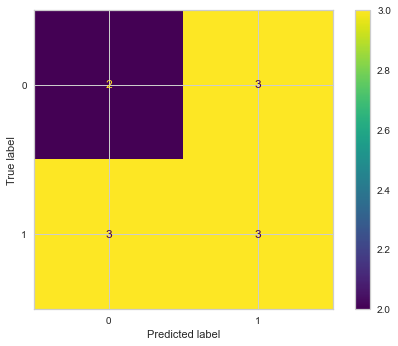

In [112]:
print(gcvt)
print(clf.best_estimator_)

test_predictions = clf.best_estimator_.predict(PV_test)
metrics.plot_confusion_matrix(clf.best_estimator_, PV_test, OV_HvMDD_test)
f1s_test_p1 = f1_score(OV_HvMDD_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(OV_HvMDD_test, test_predictions, pos_label=0)
print(f1s_test_p0)
print(f1s_test_p1)

In [113]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx),
                marker=markers[idx], label=cl)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


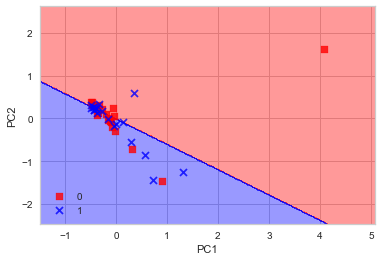

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
lr = LogisticRegression()
X_train_pca = pca.fit_transform(PV_train)
X_test_pca = pca.transform(PV_test)
lr.fit(X_train_pca, OV_HvMDD_train)
plot_decision_regions(X_train_pca, OV_HvMDD_train, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()

In [115]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import numpy as np
import matplotlib.pyplot as plt
#
def _HornParallelAnalysis(data, K=10, printEigenvalues=True):
    ################
    # Create a random matrix to match the dataset
    ################
    n, m = data.shape
    # Set the factor analysis parameters
    fa = FactorAnalyzer(n_factors=1, method='minres', rotation=None, use_smc=True)
    # Create arrays to store the values
    sumComponentEigens = np.empty(m)
    sumFactorEigens = np.empty(m)
    # Run the fit 'K' times over a random matrix
    for runNum in range(0, K):
        fa.fit(np.random.normal(size=(n, m)))
        sumComponentEigens = sumComponentEigens + fa.get_eigenvalues()[0]
        sumFactorEigens = sumFactorEigens + fa.get_eigenvalues()[1]
    # Average over the number of runs
    avgComponentEigens = sumComponentEigens / K
    avgFactorEigens = sumFactorEigens / K

    ################
    # Get the eigenvalues for the fit on supplied data
    ################
    fa.fit(data)
    dataEv = fa.get_eigenvalues()
    # Set up a scree plot
    plt.figure(figsize=(8, 6))

    ################
    ### Print results
    ################
    if printEigenvalues:
        print('Principal component eigenvalues for random matrix:\n', avgComponentEigens)
        print('Factor eigenvalues for random matrix:\n', avgFactorEigens)
        print('Principal component eigenvalues for data:\n', dataEv[0])
        print('Factor eigenvalues for data:\n', dataEv[1])
    # Find the suggested stopping points
    suggestedFactors = sum((dataEv[1] - avgFactorEigens) > 0)
    suggestedComponents = sum((dataEv[0] - avgComponentEigens) > 0)
    print('Parallel analysis suggests that the number of factors = ', suggestedFactors , ' and the number of components = ', suggestedComponents)


    ################
    ### Plot the eigenvalues against the number of variables
    ################
    # Line for eigenvalue 1
    plt.plot([0, m+1], [1, 1], 'k--', alpha=0.3)
    # For the random data - Components
    plt.plot(range(1, m+1), avgComponentEigens, 'b', label='PC - random', alpha=0.4)
    # For the Data - Components
    plt.scatter(range(1, m+1), dataEv[0], c='b', marker='o')
    plt.plot(range(1, m+1), dataEv[0], 'b', label='PC - data')
    # For the random data - Factors
    plt.plot(range(1, m+1), avgFactorEigens, 'g', label='FA - random', alpha=0.4)
    # For the Data - Factors
    plt.scatter(range(1, m+1), dataEv[1], c='g', marker='o')
    plt.plot(range(1, m+1), dataEv[1], 'g', label='FA - data')
    plt.title('Parallel Analysis Scree Plots', {'fontsize': 20})
    plt.xlabel('Factors/Components', {'fontsize': 15})
    plt.xticks(ticks=range(1, m+1), labels=range(1, m+1))
    plt.ylabel('Eigenvalue', {'fontsize': 15})
    plt.legend()
    plt.show();

Principal component eigenvalues for random matrix:
 [3.89862279 3.48773389 3.21470561 2.95951372 2.76868758 2.57391855
 2.40719122 2.25087955 2.10834837 1.97437562 1.84440832 1.73386739
 1.62284172 1.51788216 1.42360976 1.32569464 1.24127324 1.15269119
 1.07104046 0.9990055  0.93847058 0.86983946 0.81350992 0.75903542
 0.7036272  0.65251361 0.61078734 0.56443628 0.53212714 0.49926669
 0.46930059 0.44690841 0.42234163 0.40259028 0.38779693 0.37617758
 0.36783142 0.36314823]
Factor eigenvalues for random matrix:
 [ 2.72445569  2.20003228  1.94043012  1.69847655  1.51640606  1.33229642
  1.1757848   1.02802927  0.90056374  0.77905894  0.65721021  0.55764574
  0.46063929  0.37007116  0.28388265  0.19340886  0.12252027  0.04529432
 -0.02719257 -0.09210152 -0.14039705 -0.19281773 -0.24158372 -0.28574382
 -0.32821912 -0.36861604 -0.40649604 -0.43690025 -0.46299222 -0.48386069
 -0.50543078 -0.52161962 -0.53769025 -0.55056022 -0.55969016 -0.56685164
 -0.57312612 -0.57986113]
Principal component

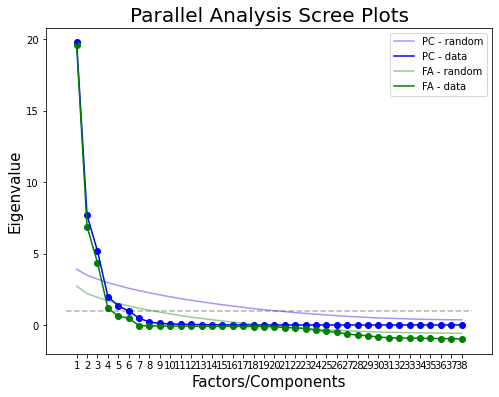

In [29]:
_HornParallelAnalysis(PV_train, K=100)

In [116]:
from sklearn.decomposition import PCA

pca_full = PCA(n_components=PVs_scaled.shape[1])
pca_full.fit(PVs_scaled)
x_pca_full = pca_full.transform(PVs_scaled)

# Variance explained by all features (should always be 100)
sum(pca_full.explained_variance_ratio_ * 100), pca_full.explained_variance_ratio_ * 100

(100.00000000000003,
 array([4.63807535e+01, 2.35305093e+01, 1.54116591e+01, 4.20430922e+00,
        3.04514795e+00, 2.64694507e+00, 2.26039305e+00, 1.01889452e+00,
        4.59697829e-01, 3.08433188e-01, 2.11346453e-01, 1.57127899e-01,
        1.38435070e-01, 7.35426066e-02, 5.11504469e-02, 2.90021362e-02,
        2.16281356e-02, 1.69190898e-02, 8.76561810e-03, 7.67622227e-03,
        4.55107523e-03, 4.14747521e-03, 2.73155699e-03, 1.90962110e-03,
        1.60070537e-03, 9.51894811e-04, 6.44214118e-04, 3.35162226e-04,
        2.91176677e-04, 1.60730818e-04, 1.04550492e-04, 7.51811079e-05,
        6.48683520e-05, 3.53970919e-05, 2.37472952e-05, 2.01660374e-05,
        9.71602925e-06, 6.36887085e-06]))

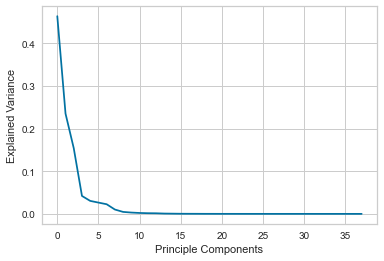

In [117]:
plt.plot(pca_full.explained_variance_ratio_)
plt.xlabel('Principle Components')
plt.ylabel('Explained Variance')
plt.show()

In [118]:
for i in range(10):
    print('Variance explained for', i, 'components is:',  np.cumsum(pca_full.explained_variance_ratio_ * 100)[i])

Variance explained for 0 components is: 46.38075349008349
Variance explained for 1 components is: 69.91126277435583
Variance explained for 2 components is: 85.32292187654073
Variance explained for 3 components is: 89.52723110098931
Variance explained for 4 components is: 92.57237905152655
Variance explained for 5 components is: 95.21932412046873
Variance explained for 6 components is: 97.4797171724022
Variance explained for 7 components is: 98.4986116966246
Variance explained for 8 components is: 98.95830952594422
Variance explained for 9 components is: 99.26674271413874


In [119]:
pca_95 = PCA(n_components = 0.95)
pca_95.fit(PVs_scaled)
x_pca_95 = pca_95.transform(PVs_scaled)

PV_pca = pd.DataFrame(x_pca_95, columns=['PC' + str(i+1) for i in range(pca_95.explained_variance_ratio_.shape[0])])
PV_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.287553,0.065170,-0.032305,-0.007275,0.062422,-0.044227
1,-0.082031,-0.079675,-0.069643,0.061157,-0.043010,-0.064332
2,0.063184,-0.342718,-0.211292,-0.008905,-0.094022,-0.091861
3,0.013328,-0.091238,-0.151837,0.002168,-0.105391,0.041861
4,-0.014683,-0.143565,-0.175982,-0.023939,-0.060824,-0.045757


In [120]:
PV_pca_train, PV_pca_test = model_selection.train_test_split(PV_pca, test_size=0.2, random_state=42)

In [122]:
# Train the classifier
# Specify parameters
kernel_choice = 'linear'
# C is the Regularizaton Parameter
# C Multiplies the Loss Function
# So the lower C is, the Softer the penalty for violating the boundaries
# So the higher C is, the Harder the penalty for violating the boundaries
# C is related to the "slack variable", which determines how fuzzy the classificaton
# boundaries are
C = 10000
gamma_choice = 'auto' # irrelevant for linear kernels
degree_choice = 10 #irrelevant unless there is a polynomial kernel

# Specify our object
from sklearn.svm import SVC
MySVC_pca = SVC(C = C, kernel = kernel_choice, gamma = gamma_choice, degree = degree_choice, random_state=100)

# Train our SVC
from sklearn.preprocessing import scale as CenterScale
MySVC_pca.fit(CenterScale(PV_pca_train), OV_HvMDD_train)

SVC(C=10000, degree=10, gamma='auto', kernel='linear', random_state=100)

In [123]:
MySVC_pca

SVC(C=10000, degree=10, gamma='auto', kernel='linear', random_state=100)

Number of Support Vectors for each Class = [14 13]
AUC = 0.6166666666666667
Balanced Accuracy = 0.6166666666666667
F1 = 0.7142857142857143
Matthews Correlation Coefficient: 0.2608745973749754
Log Loss: 12.55977312472121


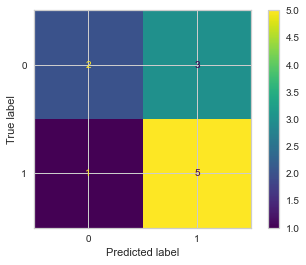

In [124]:
# Explore our classifier
print('Number of Support Vectors for each Class = ' + str(MySVC_pca.n_support_))
#print('Median of Feature Weights (only available for Linear Kernel) = ' + str(np.median(MySVC.coef_)))
#print('Maximum of Feature Weights (only available for Linear Kernel) = ' + str(np.max(MySVC.coef_)))

# Test the classifier
TestPred = MySVC_pca.predict(CenterScale(PV_pca_test))
AUCResult = metrics.roc_auc_score(OV_HvMDD_test, TestPred)
print('AUC = ' + str(AUCResult))
BalAccResult = metrics.balanced_accuracy_score(OV_HvMDD_test, TestPred)
print('Balanced Accuracy = ' + str(BalAccResult))
F1Result = metrics.f1_score(OV_HvMDD_test, TestPred)
print('F1 = ' + str(F1Result))

print('Matthews Correlation Coefficient:', metrics.matthews_corrcoef(OV_HvMDD_test, TestPred))
print('Log Loss:', metrics.log_loss(OV_HvMDD_test, TestPred))

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(OV_HvMDD_test, TestPred)).plot()